# Import

In [26]:
# 토치 버전확인
import torch
print(torch.__version__)

1.12.0


In [27]:
# 라이브러리 세팅

import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A #증강
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split

In [28]:
# GPU 확인
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [29]:
# EfficientNet 오류 안나게..
torch.backends.cudnn.enabled = False

# Hyerparameter Setting

In [30]:
CFG = {
    'IMG_SIZE':456,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':42
}

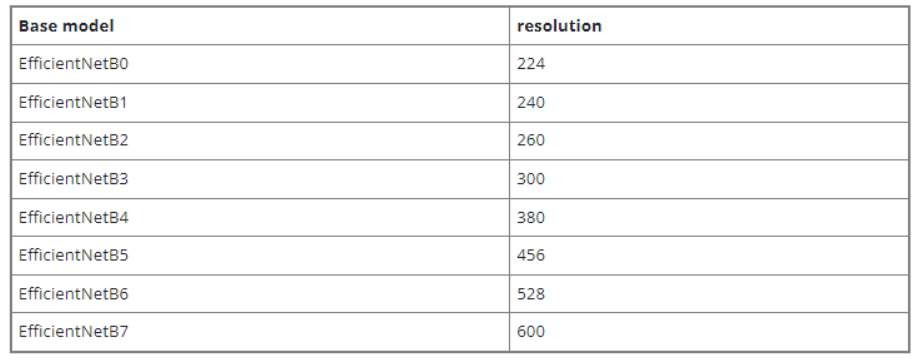

# Fixed RandomSeed

In [31]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# Data Load

In [32]:
df=pd.read_csv('../train.csv')

# Train-Valid Split

In [33]:
# 구조물
tmp=df.copy()
tmp['sum']=tmp.loc[:,'A':].sum(axis=1)
tmp.loc[(tmp['sum']==8) | (tmp['sum']==9),'sum']=8.5

In [34]:
tmp['img_path']='.'+tmp['img_path'].str.replace('train','new_train')
tmp['img_path']=tmp['img_path'].str.replace('TRAIN','new_train')
tmp['img_path']=tmp['img_path'].str.replace('jpg','png')

In [35]:
train,valid=train_test_split(tmp,test_size=0.2,stratify=tmp['sum'],random_state=42)

In [36]:
train.drop('sum',axis=1,inplace=True)
valid.drop('sum',axis=1,inplace=True)

In [37]:
tmp['img_path']

0        ../new_train/new_train_00000.png
1        ../new_train/new_train_00001.png
2        ../new_train/new_train_00002.png
3        ../new_train/new_train_00003.png
4        ../new_train/new_train_00004.png
                       ...               
32989    ../new_train/new_train_32989.png
32990    ../new_train/new_train_32990.png
32991    ../new_train/new_train_32991.png
32992    ../new_train/new_train_32992.png
32993    ../new_train/new_train_32993.png
Name: img_path, Length: 32994, dtype: object

In [38]:
len(train), len(valid)

(26395, 6599)

In [39]:
pwd

'D:\\deeplearning\\0118'

# Data Preprocessing

In [40]:
def get_labels(df):
    return df.iloc[:,2:].values

In [41]:
train_labels=get_labels(train)
valid_labels=get_labels(valid)

# CustomDataset

In [42]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = torch.FloatTensor(self.label_list[index])
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [43]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [44]:
train_dataset = CustomDataset(train['img_path'].values, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

valid_dataset = CustomDataset(valid['img_path'].values, valid_labels, test_transform)
valid_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [45]:
for x,y in train_loader:
    print(f'Image shape : {x.shape}')
    print(f'Label shape : {y.shape}')
    break

Image shape : torch.Size([16, 3, 456, 456])
Label shape : torch.Size([16, 10])


# Model Define

In [46]:
from efficientnet_pytorch import EfficientNet

In [47]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b3(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
        ######
        
    def forward(self, x):
        x = self.backbone(x)
        
        ######
        
        x = F.sigmoid(self.classifier(x))
        return x

In [48]:
def train(model, optimizer, train_loader, valid_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    best_valid_acc = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _valid_loss, _valid_acc = validation(model, criterion, valid_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Valid Loss : [{_valid_loss:.5f}] Valid ACC : [{_valid_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_valid_acc)
            
        if best_valid_acc < _valid_acc:
            best_valid_acc = _valid_acc
            best_model = model
    
    return best_model

In [49]:
def validation(model, criterion, valid_loader, device):
    model.eval()
    valid_loss = []
    valid_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(valid_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            valid_acc.append(batch_acc)
            valid_loss.append(loss.item())
        
        _valid_loss = np.mean(valid_loss)
        _valid_acc = np.mean(valid_acc)
    
    return _valid_loss, _valid_acc

# Run!

In [50]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, valid_loader, scheduler, device)

  0%|          | 0/1650 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.21808] Valid Loss : [0.09012] Valid ACC : [0.96628]


  0%|          | 0/1650 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.08387] Valid Loss : [0.06254] Valid ACC : [0.97667]


  0%|          | 0/1650 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.05914] Valid Loss : [0.05686] Valid ACC : [0.97997]


  0%|          | 0/1650 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.04676] Valid Loss : [0.04915] Valid ACC : [0.98216]


  0%|          | 0/1650 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.03849] Valid Loss : [0.04874] Valid ACC : [0.98342]


# Inference

In [51]:
test = pd.read_csv('../test.csv')

In [52]:
test['img_path']='.'+test['img_path']
test['img_path']=test['img_path'].str.replace('test','new_test')
test['img_path']=test['img_path'].str.replace('TEST','new_test')
test['img_path']=test['img_path'].str.replace('jpg','png')

In [53]:
test['img_path'][0]

'../new_test/new_test_00000.png'

In [54]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [55]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            probs = model(imgs)

            probs  = probs.cpu().detach().numpy()
            preds = probs > 0.5
            preds = preds.astype(int)
            predictions += preds.tolist()
    return predictions

In [56]:
# 확인용
valid_dataset2 = CustomDataset(valid['img_path'].values, None, test_transform)
valid_loader2 = DataLoader(valid_dataset2, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [57]:
val_preds = inference(infer_model, valid_loader2, device)

  0%|          | 0/413 [00:00<?, ?it/s]

In [58]:
pd.DataFrame(val_preds).sum(axis=1).value_counts()

4     1557
5     1457
3     1283
6     1016
2      589
7      514
1      161
8       14
10       5
0        3
dtype: int64

In [59]:
valid.loc[:,'A':].sum(axis=1).value_counts()

4     1635
5     1390
3     1152
6     1107
7      576
2      576
1      158
10       5
dtype: int64

In [60]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/92 [00:00<?, ?it/s]

# Submission

In [61]:
submit = pd.read_csv('../sample_submission.csv')

submit.iloc[:,1:] = preds
submit.head()

submit.to_csv('./0118_ENB5_rmbg_submit.csv', index=False)